<a href="https://colab.research.google.com/github/Ibrahimsyah/Foories/blob/ml/notebooks/02_Model_Training_%26_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing datasets

In [ ]:
!pip install gdown -q

In [97]:
!pip install numpy scikit-learn matplotlib

In [94]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import sklearn.metrics
from google.colab import drive
import os
import pathlib
import numpy as np
import matplotlib.pylab as plt

In [47]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the directory you want to list
directory_path = '/content/drive/My Drive/Bangkit/content/content'

# Check if the directory exists
if os.path.exists(directory_path):
    # List the contents of the directory
    files = os.listdir(directory_path)
    print(f"Contents of '{directory_path}':")
    for file in files:
        print(file)
else:
    print(f"The directory '{directory_path}' does not exist.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of '/content/drive/My Drive/Bangkit/content/content':
dataset
dataset_baru


In [48]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the directory paths
base_dir = "/content/drive/My Drive/Bangkit/content/content/dataset"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "dev")
test_dir = os.path.join(base_dir, "test")

# Create the directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

print("Directories created successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directories created successfully!


In [ ]:
def rotate_images(input_folder, output_folder, rotation_angles):
    # Pastikan folder output ada, jika tidak maka buat folder tersebut
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterasi melalui semua file di folder input
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Baca gambar
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)

            # Rotasi gambar dan simpan
            for angle in rotation_angles:
                rotated_img = img.rotate(angle)
                rotated_filename = f"{os.path.splitext(filename)[0]}_rotated_{angle}{os.path.splitext(filename)[1]}"
                rotated_img.save(os.path.join(output_folder, rotated_filename))

In [ ]:
input_folder = "/content/drive/My Drive/Bangkit/content/content/dataset/train/Sop"
output_folder = "/content/drive/My Drive/Bangkit/content/content/dataset_baru/train/Sop"
rotation_angles = [90, 180, 270]  # Derajat rotasi yang diinginkan

rotate_images(input_folder, output_folder, rotation_angles)

In [49]:
handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


# Making ImageGenerator

In [50]:
BATCH_SIZE = 64 #@param {type:"integer"}

In [78]:
# Datagen
train_datagen =  ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen =  ImageDataGenerator(rescale=1./255)

# Flow training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

# Flow validation data generator
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

# Flow test data generator
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(224, 224),batch_size=BATCH_SIZE,shuffle=False,class_mode='categorical')

Found 8089 images belonging to 15 classes.
Found 1803 images belonging to 15 classes.
Found 84 images belonging to 15 classes.


In [52]:
class_names = list(train_generator.class_indices.keys())

# Create a labels.txt file with the class names

with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [53]:
feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape=IMAGE_SIZE + (3,),
    output_shape=[FV_SIZE],
    trainable=False
)

In [72]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_9 (Dense)             (None, 64)                81984     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 15)                975       
                                                                 
Total params: 2340943 (8.93 MB)
Trainable params: 82959 (324.06 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [80]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Training using MobileNet v2

In [81]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [82]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/15
127/127 [==============================] - 645s 5s/step - loss: 1.9649 - accuracy: 0.4132 - val_loss: 1.3352 - val_accuracy: 0.6412 - lr: 0.0010
Epoch 2/15
127/127 [==============================] - 643s 5s/step - loss: 1.2775 - accuracy: 0.6300 - val_loss: 1.0096 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 3/15
127/127 [==============================] - 633s 5s/step - loss: 1.0754 - accuracy: 0.6881 - val_loss: 0.9301 - val_accuracy: 0.7543 - lr: 0.0010
Epoch 4/15
127/127 [==============================] - 625s 5s/step - loss: 0.9842 - accuracy: 0.7089 - val_loss: 0.9041 - val_accuracy: 0.7659 - lr: 0.0010
Epoch 5/15
127/127 [==============================] - 687s 5s/step - loss: 0.9030 - accuracy: 0.7406 - val_loss: 0.8786 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 6/15
127/127 [==============================] - 690s 5s/step - loss: 0.8517 - accuracy: 0.7589 - val_loss: 0.8582 - val_accuracy: 0.7720 - lr: 0.0010
Epoch 7/15
127/127 [==============================] - 640s 5s/st

# Training results

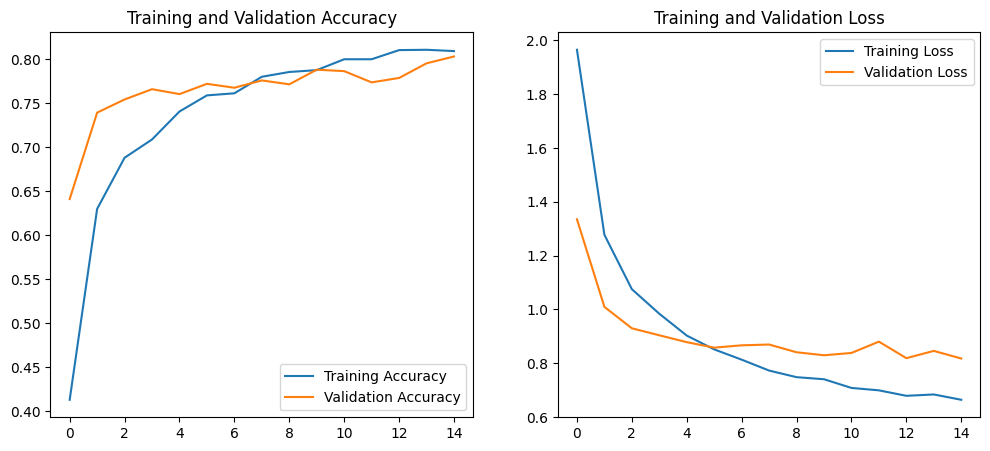

In [83]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [84]:
# Evaluate final score on Validation and Testing data

scores = model.evaluate(validation_generator)
#scores = model.evaluate(test_generator)
scores = model.evaluate(test_generator)

2/2 [==============================] - 5s 638ms/step - loss: 0.6279 - accuracy: 0.8571


## Conclusion:

Transfer Learning Mobilenet_v2 with dataset_v4:

- Training: 86.72 %
- Validation: 84.11 %
- Testing: 85.77 %

Avoidable error might be improved.

# Exporting model

In [85]:
model.save('model_v4.h5')
model.save('model_v4')
!zip -r 'model_v4.zip' 'model_v4'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  adding: model_v4/ (stored 0%)
  adding: model_v4/saved_model.pb (deflated 91%)
  adding: model_v4/assets/ (stored 0%)
  adding: model_v4/fingerprint.pb (stored 0%)
  adding: model_v4/keras_metadata.pb (deflated 85%)
  adding: model_v4/variables/ (stored 0%)
  adding: model_v4/variables/variables.index (deflated 78%)
  adding: model_v4/variables/variables.data-00000-of-00001 (deflated 8%)


In [86]:
converter = tf.lite.TFLiteConverter.from_saved_model('model_v4')

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# Invoke the converter to generate the TFLite model
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model_v4.tflite')
tflite_model_file.write_bytes(tflite_model)

2593688

# Model Evaluation and Metrics

In [99]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=class_names))



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2/2 [==============================] - 7s 1s/step
Classification Report
              precision    recall  f1-score   support

 Ayam Goreng       0.67      0.80      0.73         5
       Bakso       1.00      0.60      0.75         5
      Burger       1.00      1.00      1.00         5
       Gudeg       0.83      1.00      0.91         5
  Ikan Bakar       1.00      1.00      1.00         5
    Mie Ayam       0.83      1.00      0.91         5
 Nasi goreng       1.00      1.00      1.00         6
      Pempek       0.88      1.00      0.93         7
       Rawon       0.86      1.00      0.92         6
     Rendang       1.00      0.67      0.80         6
        Sate       0.86      1.00      0.92         6
         Sop       0.80      0.57      0.67         7
        Soto       0.62      0.83      0.71         6
       Telur       0.75      0.60      0.67         5
       Tempe       1.00      0.80      0.89         5

    accuracy                           0.86        84
   macro

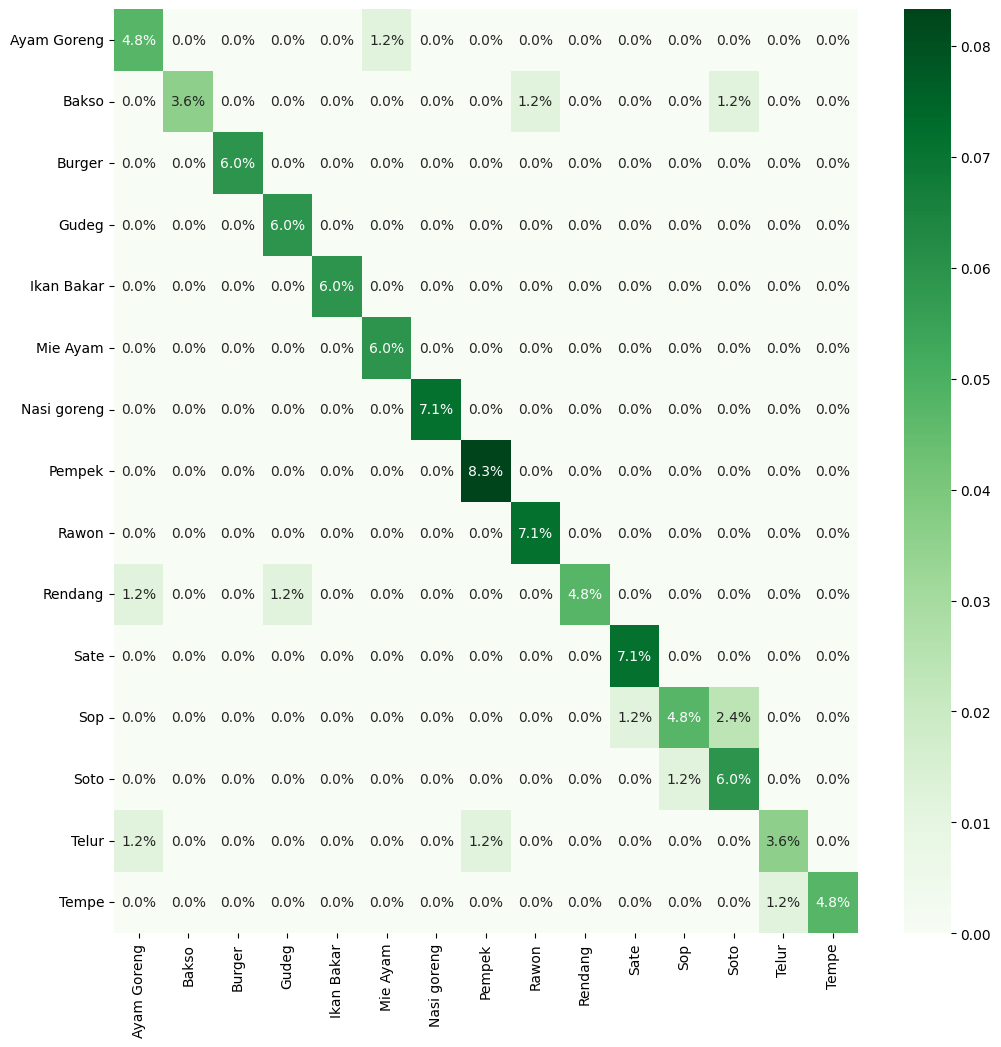

In [100]:
import seaborn as sns

plt.figure(figsize=(12,12))
ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap="Greens", xticklabels=class_names, yticklabels=class_names)

plt.show()

## Notes on improvement

- Soto and Bakso are similar in appearance. Might need to add diverse data for those two classes